In [88]:
import os
import warnings
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

from sklearn.cluster import MeanShift
from sklearn.neighbors.kde import KernelDensity


latex_fonts = {
    'mathtext.fontset': 'cm', # or 'stix'
    'font.family': 'cmss10', # or 'STIXGeneral
    "text.usetex": True,
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
}
mpl.rcParams.update(latex_fonts)



class InverseBallisticsModel():

    n_parameters = 4
    n_observations = 1
    name = 'inverse-ballistics'

    def __init__(self, g=9.81, k=0.25, m=0.2):
        self.name = 'inverse-ballistics'

        self.g = g # gravity
        self.k = k # drag coefficient dependent on object shape and traversed medium
        self.m = m # object mass

        self.xy_mu = np.array((0, 1.5))
        self.xy_std = np.array((0.5, 0.5))

    def sample_prior(self, N):
        x = np.random.randn(N, 1) * self.xy_std[0] + self.xy_mu[0]
        y = np.random.randn(N, 1) * self.xy_std[1] + self.xy_mu[1]
        y = np.maximum(y, 0)
        angle = np.random.rand(N, 1) * np.pi/2 * 0.8 + np.pi/2 * 0.1
        v0 = np.random.poisson(15, (N, 1))
        return np.concatenate([x, y, angle, v0], axis=1)

    def trajectories_from_parameters(self, x):
        x0, y0, angle, v0 = np.split(x, 4, axis=1)
        v0 = np.repeat(v0, 1500, axis=-1)
        angle = np.repeat(angle, 1500, axis=-1)
        t = np.repeat(np.linspace(0, 6, 1500)[None,:], x.shape[0], axis=0)
        vx = v0 * np.cos(angle)
        vy = v0 * np.sin(angle)

        expterm = np.exp(-self.k*t / self.m) - 1
        xt = x0 - (vx*self.m / self.k) * expterm
        yt = y0 - (self.m/(self.k*self.k)) * ((self.g*self.m + vy*self.k) * expterm + self.g*t*self.k)
        return xt, yt
    
    ###############
    # Modify part #
    ###############
    
    def impact_from_trajectories(self, xs, ys):
        # First find the peak of the trajectgory
        ys_peak = np.argmax(ys, axis=1)
        # Threshold it to the trajectory that is after the peak, put 0.1 for all values before peak
        ys_after_peak = np.where(xs < xs[np.arange(xs.shape[0]), ys_peak][:,None], 0.1, ys)
        # Get the impact index by getting the place where the sign flips
        xs_impact_index = np.diff(np.signbit(ys_after_peak))
        #print("The xs_impact_index is", xs_impact_index)
        xs_impact_index = xs_impact_index.nonzero()
        #print("After non_zero: The xs_impact_index is", xs_impact_index[0])
        # Get the impact point
        xs_impact = xs[xs_impact_index]
        return xs_impact, xs_impact_index[0]

    def forward_process(self, x, output_full=False):
        """
        :param output_full: Output the full_array where the shape is the same as input
        The invalid ones would be filled with -1 and won't be calculated in the MSE calculation
        """
        #print("This is forward process, the shape of input x is:", np.shape(x))
        #print("The type of input x is:", type(x))
        xs, ys = self.trajectories_from_parameters(x)
        y_final, valid_index = self.impact_from_trajectories(xs, ys)
        y_final = y_final[:,None]
        print("This is forward process, the shape of output y is:", np.shape(y_final))
        if output_full:
            output = -1 * np.ones(len(x))
            z = 0
            print("output is ", output)
            for i in valid_index:
                output[i] = y_final[z]
                z = z + 1
            return output
        return y_final

    def init_plot(self, y_target):
        return plt.figure(figsize=(8,8))

    def update_plot(self, x, y_target):
        plt.gcf().clear()
        x = np.array(x)
        xs, ys = self.trajectories_from_parameters(x)

        # Trajectories
        lines = np.stack([xs, ys], axis=-1)
        lines = [np.squeeze(line) for line in np.split(lines, len(lines))]
        line_collection = LineCollection(lines, linewidths=1, alpha=0.1, rasterized=True)
        plt.gca().add_collection(line_collection)

        # Arrows for initial velocity
        x0, y0, angle, v0 = [np.squeeze(p) for p in np.split(x, 4, axis=1)]
        vx = v0 * np.cos(angle)
        vy = v0 * np.sin(angle)
        plt.quiver(x0, y0, vx, vy, angles='xy', scale_units='xy',
                   scale=15, width=0.001, headwidth=3, color='red', alpha=0.2,
                   zorder=10, rasterized=True)

        # Impact points
        xs_impact, _ = self.impact_from_trajectories(xs, ys)
        plt.scatter(xs_impact, np.zeros(xs_impact.shape),
                    s=5, edgecolor='red', facecolor='white', alpha=0.2,
                    zorder=20, rasterized=True)

        # Target
        plt.axhline(0, color='k', linestyle='dotted', linewidth=1)
        plt.axvline(y_target, color='k', linewidth=1)

        plt.gca().set_aspect('equal', 'datalim')
        plt.xlim([np.amin(xs) - 0.5, np.amax(xs_impact) + 0.5])
        plt.ylim([-0.5, np.amax(ys) + 0.5])
        plt.gca().set_xticks([]); plt.gca().set_yticks([])
        plt.tight_layout(pad=0, w_pad=-0.5, h_pad=-0.5)

    def find_MAP(self, x):
        try:
            mean_shift = MeanShift()
            mean_shift.fit(x)
            centers = mean_shift.cluster_centers_
            kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x)

            best_center = (None, -np.inf)
            dens = kde.score_samples(centers)
            for c,d in zip(centers, dens):
                if d > best_center[1]:
                    best_center = (c.copy(), d)

            dist_to_best = np.sum((x - best_center[0])**2, axis=1)
            return np.argmin(dist_to_best)
        except:
            print('Mean shift failed')
            return 0

    def arcarrow(self, start, direction, dist=2, open_angle=45,
                 kw=dict(arrowstyle='<->, head_width=2, head_length=2', ec='black', lw=1)):
        angle = np.arctan2(direction[1], direction[0])
        angle1 = angle - np.radians(open_angle/2)
        x1 = start[0] + dist * np.cos(angle1)
        y1 = start[1] + dist * np.sin(angle1)
        angle2 = angle + np.radians(open_angle/2)
        x2 = start[0] + dist * np.cos(angle2)
        y2 = start[1] + dist * np.sin(angle2)
        plt.gca().add_patch(patches.FancyArrowPatch((x1, y1), (x2, y2), connectionstyle=f"arc3, rad=.6", **kw))
        plt.text(x1+0.5, y1, r'x3', ha='center', va='center')

    def plot_sample(self, x, xs=None, ys=None, colors={}, alphas={}, annotate=False, y_target=None, xlim=[-2, 13], ylim=[-4, 11]):
        c = {'lines': (.5,.5,.5), 'arrows': (.2,.2,.2), 'impact': 'green'}
        c.update(colors)
        colors = c
        a = {'lines': 0.01, 'arrows': 0.4, 'impact': 0.2, 'density': 0.2}
        a.update(alphas)
        alphas = a

        if xs is None or ys is None:
            xs, ys = self.trajectories_from_parameters(x)
        exemplar = self.find_MAP(x)

        # Trajectories
        lines = np.stack([xs, ys], axis=-1)
        lines = [np.squeeze(line) for line in np.split(lines, len(lines))]
        line_collection = LineCollection(lines, colors=colors['lines'], linewidths=1, alpha=alphas['lines'], zorder=1, rasterized=True)
        plt.gca().add_collection(line_collection)
        # Exemplar trajectory
        plt.plot(xs[exemplar], ys[exemplar], color=(0,0,0), linewidth=1, linestyle='dashed', zorder=100)

        # Arrows for initial velocity
        x0, y0, angle, v0 = [np.squeeze(p) for p in np.split(x[:150], 4, axis=1)]
        vx = v0 * np.cos(angle)
        vy = v0 * np.sin(angle)
        plt.quiver(x0, y0, vx, vy, angles='xy', scale_units='xy',
                   scale=15, width=0.001, headwidth=7, color=colors['arrows'], alpha=alphas['arrows'],
                   zorder=10, rasterized=True)
        # Exemplar arrow
        x0, y0, angle, v0 = x[exemplar]
        vx = v0 * np.cos(angle)
        vy = v0 * np.sin(angle)
        plt.arrow(x0, y0, vx/5, vy/5,
                  width=0.003, head_width=0.15, color=(0,0,0),
                  zorder=101)
        plt.scatter([x0-0.02], [y0], s=10, edgecolor='black', facecolor='white', zorder=102)
        if annotate:
            self.arcarrow([x0,y0], [vx/5,vy/5])
            plt.text(x0+vx/5 - 0.3, y0+vy/5 + 0.5, r'x4', ha='center', va='center')
            plt.text(-0.7, 0.7, r'(x1,x2)', ha='center', va='center')

        # Impact points
        xs_impact, _ = self.impact_from_trajectories(xs, ys)
        exemplar_impact, _ = self.impact_from_trajectories(xs[exemplar:exemplar+1], ys[exemplar:exemplar+1])
        if len(xs_impact) > 0:
            plt.scatter(xs_impact, np.zeros(xs_impact.shape),
                        s=5, edgecolor=colors['impact'], facecolor='white', alpha=alphas['impact'],
                        zorder=20, rasterized=True)
            if len(exemplar_impact) > 0:
                plt.scatter([exemplar_impact], [0], s=10, edgecolor='black', facecolor='white',
                            zorder=102)
                if annotate:
                    plt.text(exemplar_impact-0.3, -0.5, r'y', ha='center', va='center')
            # Density
            from scipy.stats import gaussian_kde
            density = gaussian_kde(xs_impact)
            density.covariance_factor = lambda: .15
            density._compute_covariance()
            domain = np.linspace(np.amin(xs_impact)-.5, np.amax(xs_impact)+.5, 200)
            density = density(domain)
            plt.fill_between(domain, 5*density/np.amax(density), color=colors['impact'], alpha=alphas['density'])

        # X axis
        plt.axhline(0, color='gray', linestyle='dotted', linewidth=1, alpha=.5)
        if y_target:
            plt.axvline(y_target, color='gray', linestyle='dotted', linewidth=1, alpha=.5)

        plt.gca().set_aspect('equal', 'datalim')
        plt.gca().set_xticks([]); plt.gca().set_yticks([])
        plt.xlim(xlim); plt.ylim(ylim)



class InverseBallisticsDataset(Dataset):

    def __init__(self, model, n, root_dir=None, suffix=''):
        self.model = model
        self.root_dir = root_dir
        if root_dir is None:
            warnings.warn('InverseBallisticsDataset: No data directory specified, generated data will not be stored.', Warning)
        self.n = n
        self.suffix = suffix
        if len(suffix) > 0 and not '_' in suffix[:1]:
            suffix = '_' + suffix

        try:
            x = np.load(f'{root_dir}/{self.model.name}_x{suffix}.npy')[:n,...]
        except Exception as e:
            print(f'InverseBallisticsDataset: Not enough data for model "{self.model.name}" found, generating {n} new samples...')
            x = model.sample_prior(n)
            if root_dir is not None:
                os.makedirs(root_dir, exist_ok=True)
                np.save(f'{root_dir}/{self.model.name}_x{suffix}', x)
        self.x = x
        try:
            y = np.load(f'{root_dir}/{self.model.name}_y{suffix}.npy')[:n,...]
        except Exception as e:
            print(f'InverseBallisticsDataset: Not enough labels for model "{self.model.name}" found, running forward process on {n} samples...')
            y = []
            if n > 100000:
                for i in range((n-1)//100000 + 1):
                    print(f'InverseBallisticsDataset: Forward process chunk {i+1}...')
                    y.append(model.forward_process(x[100000*i : min(n, 100000*(i+1)),...]))
                y = np.concatenate(y, axis=0)
            else:
                y = model.forward_process(x)
            print()
            if root_dir is not None:
                np.save(f'{root_dir}/{self.model.name}_y{suffix}', y)
        self.y = y

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        return self.x[i], self.y[i]

    def get_dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=True, drop_last=True)





/Users/ben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:252: Warning: InverseBallisticsDataset: No data directory specified, generated data will not be stored.


InverseBallisticsDataset: Not enough data for model "inverse-ballistics" found, generating 100 new samples...
InverseBallisticsDataset: Not enough labels for model "inverse-ballistics" found, running forward process on 100 samples...
This is forward process, the shape of output y is: (100, 1)

torch.Size([100, 4]) torch.Size([100, 1])


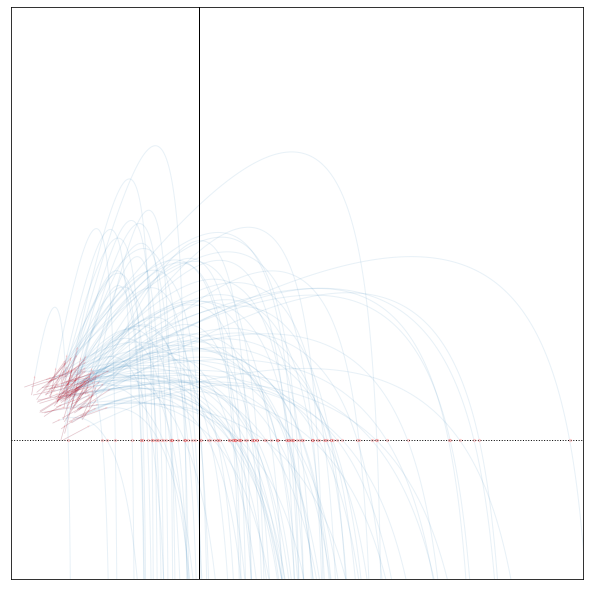

In [89]:
if __name__ == '__main__':
    pass

    model = InverseBallisticsModel()
    train_data = InverseBallisticsDataset(model, 100, None, suffix='train')
    train_loader = train_data.get_dataloader(100)
    
    with open("data_x.csv", 'a') as file_x, open("data_y.csv",'a') as file_y:
        for x,y in train_loader:
            print(x.shape, y.shape)

            fig = model.init_plot(y_target=5)
            model.update_plot(x, y_target=5)
            np.savetxt(file_x, x,delimiter=',')
            np.savetxt(file_y, y,delimiter=',')
            #print(x, y)
            #break

### Read the input files

In [31]:
import pandas as pd
Xt = pd.read_csv('../0408/test_Xtruth_20200407_105922.csv', header=None,sep=' ')
Xp = pd.read_csv('../0408/test_Xpred_20200407_105922.csv', header=None,sep=' ')
Yt = pd.read_csv('../0408/test_Ytruth_20200407_105922.csv', header=None,sep=' ')
Yp = pd.read_csv('../0408/test_Ypred_20200407_105922.csv', header=None,sep=' ')

In [32]:
print(np.shape(Xt))
print(np.shape(Xp))
print(np.shape(Yt))
print(np.shape(Yp))
print(Xp)

(13000, 4)
(13000, 4)
(13000, 1)
(13000, 1)
           0      1      2       3
0      0.274  1.645  0.571  12.966
1      0.179  1.209  0.974  20.151
2     -0.526  0.880  1.231  14.566
3     -0.561  1.142  1.159  18.142
4     -0.243  1.782  0.972  12.441
...      ...    ...    ...     ...
12995 -0.187  1.633  0.453  13.926
12996 -0.043  2.162  0.296  16.814
12997 -0.322  2.078  0.865  13.738
12998 -0.977  1.686  1.097  16.589
12999  0.255  0.922  0.557  12.105

[13000 rows x 4 columns]


### Get the prediction files from simulator given

In [92]:
IB = InverseBallisticsModel()
IB_Yt = IB.forward_process(Xt.values)
IB_Yp = IB.forward_process(Xp.values, output_full=True)
valid_index = IB_Yp != -1
MSE_Yt = np.square(Yt.values - IB_Yt)
MSE_Yp = np.square(Yp.values[valid_index] - IB_Yp[valid_index])
print(np.shape(MSE_Yt))
#n, bins, patches = plt.hist(MSE)

This is forward process, the shape of output y is: (13000, 1)
This is forward process, the shape of output y is: (12999, 1)
output is  [-1. -1. -1. ... -1. -1. -1.]
(13000, 1)


In [67]:
Xp_first10 = Xp.values[1:300, :]
Yp_first10 = Yp.values[1:300, :]
print(np.shape(Xp_first10))
IB_Yp = IB.forward_process(Xp_first10)
print(np.shape(IB_Yp))
MSE_Yp = np.square(Yp_first10 - IB_Yp)
print(np.max(MSE_Yp))
wrong_ones = MSE_Yp > 1
print(np.sum(wrong_ones))
print(wrong_ones)
print(np.shape(wrong_ones))

(299, 4)
This is forward process, the shape of input x is: (299, 4)
The type of input x is: <class 'numpy.ndarray'>
This is forward process, the shape of output y is: (298, 1)
(298, 1)


ValueError: operands could not be broadcast together with shapes (299,1) (298,1) 

In [63]:
Xp_wrong_ones = Xp_first10[np.ravel(wrong_ones),:]
print("The wrong ones are:", Xp_wrong_ones)
print("My solutions are:", Yp_first10[np.ravel(wrong_ones),:])
print("Author solutions are:", IB.forward_process(Xp_wrong_ones))

The wrong ones are: [[ 9.6500e-01 -1.6000e-02  2.2000e-01  1.9610e+01]
 [-2.2500e-01 -1.5000e-01  4.1000e-01  9.8480e+00]
 [-6.0400e-01 -5.9000e-02  3.3200e-01  1.6347e+01]
 [-4.1700e-01 -4.0000e-03  4.5300e-01  1.3398e+01]
 [ 2.9000e-02 -1.1400e-01  2.9700e-01  2.2932e+01]
 [-3.1700e-01 -1.5300e-01  6.9500e-01  7.6310e+00]
 [ 1.0990e+00 -1.7900e-01  3.0200e-01  1.2843e+01]
 [ 9.4300e-01 -6.5000e-02  2.4700e-01  2.2509e+01]]
My solutions are: [[ 1.039]
 [ 0.139]
 [-0.432]
 [-0.408]
 [ 0.406]
 [-0.127]
 [ 1.714]
 [ 1.204]]
This is forward process, the shape of input x is: (8, 4)
The type of input x is: <class 'numpy.ndarray'>
This is forward process, the shape of output y is: (8, 1)
Author solutions are: [[10.26818485]
 [ 3.77176995]
 [ 7.72852787]
 [ 6.43373947]
 [13.07304205]
 [ 2.64804621]
 [ 6.34609137]
 [12.87923092]]


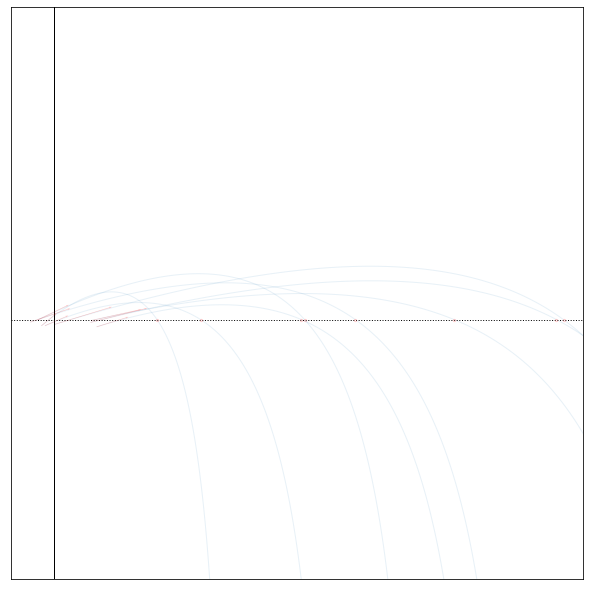

In [64]:
fig = model.init_plot(y_target=0)
model.update_plot(Xp_wrong_ones, y_target=0)
fig.savefig('plot.png')

In [56]:
sorted_MSE = np.sort(MSE_Yp, axis=None, )
print(sorted_MSE)

[2.99180166e-14 4.48854040e-13 8.72193107e-13 ... 8.51778531e+01
 1.36311017e+02 1.60453954e+02]


In [54]:
print(MSE_Yp)

[[1.35162543e-05]
 [1.92546931e-04]
 [7.01056058e-06]
 ...
 [5.82342070e-07]
 [7.26862784e-07]
 [1.10315385e-05]]
